# Tutorial 4: 10x Visium human breast cancer dataset
We performed recovery and generation experiments on the human breast cancer section 1. In this tutorial, we only focus on generation experiment. On the tissue section, we generated unmeasured spots in the gaps of the measured spots, which are three times the number of the measured spots. We got high-density generated gene expression profiles by STAGE.

Then we performed tissue segmentation by integration with a human breast cancer scRNA-seq dataset. we got differential expression analysis results on this dataset and predicted cell types distribution scores which can be used to segment tissue sections. We performed above analysis on both raw and generated ST data.

The 10x Visium data can be downloaded from [10x genomic website](https://www.10xgenomics.com/resources/datasets/human-breast-cancer-block-a-section-1-1-standard-1-0-0). 
The scRNA-seq data with cell type annotations are available at Gene Expression Omnibus (GEO) accession [GSE176078](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE176078). We also provided SCANPY object at [Google Drive](https://drive.google.com/drive/folders/1grM5nO2NkRH2PXMZLejXrOB_U0N3N65G).

## Data preprocessing

In [1]:
import warnings
warnings.filterwarnings("ignore")
import STAGE
import scanpy as sc
import matplotlib.pyplot as plt
import os
import pandas as pd
import scipy.sparse as sp
from sklearn.cluster import KMeans

In [2]:
input_dir = 'Data/T4'
adata = sc.read_visium(path=input_dir, count_file='filtered_feature_bc_matrix.h5')
adata.var_names_make_unique()

In [3]:
# Coordinates (array_col, array_row)
adata.obsm["coord"]=adata.obs.loc[:, ['array_col', 'array_row']].to_numpy()

In [4]:
# Normalization
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [5]:
adata

AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatial', 'hvg', 'log1p'
    obsm: 'spatial', 'coord'

## Running model

In [6]:
adata_stage=STAGE.STAGE(
    adata, 
    save_path='./T4_breast_cancer', 
    data_type='10x', 
    experiment='generation', 
    coord_sf=77, 
    train_epoch=10000, 
    seed=123, 
    batch_size=512, 
    learning_rate=1e-3, 
    w_recon=0.1, 
    w_w=0.1, 
    w_l1=0.1,
    relu=True,
    device='cuda:0'
)

Epochs: 100%|██████████| 10000/10000 [2:38:37<00:00,  1.05it/s, latent_loss: 0.00343, recon_loss: 0.07862, total_loss: 0.00113] 


In [7]:
adata_stage

AnnData object with n_obs × n_vars = 15192 × 3000
    obsm: 'coord'

## Integration with scRNA-seq data

In [8]:
input_dir = 'Data/T4/all_scRNASeq'
adata_sc=sc.read_mtx(os.path.join(input_dir,"matrix.mtx"))
adata_sc=sc.AnnData(adata_sc.X.T)

In [9]:
gene=pd.read_csv(os.path.join(input_dir,"genes.tsv"), index_col=0, header=None)
barcode=pd.read_csv(os.path.join(input_dir,"barcodes.tsv"), index_col=0, header=None)
meta=pd.read_csv(os.path.join(input_dir,"metadata.csv"), index_col=0)

adata_sc.obs.index=barcode.index.values
adata_sc.var.index=gene.index.values
adata_sc.obs.loc[meta.index,meta.columns]=meta

In [10]:
# Normalization
sc.pp.highly_variable_genes(adata_sc, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata_sc, target_sum=1e4)
sc.pp.log1p(adata_sc)

In [11]:
adata_sc.obs["celltype_major"].value_counts()

T-cells              35214
Cancer Epithelial    24489
Myeloid               9675
Endothelial           7605
CAFs                  6573
PVL                   5423
Normal Epithelial     4355
Plasmablasts          3524
B-cells               3206
Name: celltype_major, dtype: int64

In [12]:
# Differential expression analysis
sc.tl.rank_genes_groups(adata_sc, 'celltype_major', method='wilcoxon')

In [13]:
adata_sc

AnnData object with n_obs × n_vars = 100064 × 29733
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'subtype', 'celltype_subset', 'celltype_minor', 'celltype_major'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups'

In [14]:
# Identifying differential expression genes
DE_df = sc.get.rank_genes_groups_df(adata_sc, group=None, log2fc_min=4)
DE_df = DE_df[DE_df.pvals_adj<0.05]
DE_df = DE_df[DE_df.names.isin(adata_stage.var.index)]
DE_df

,group,names,scores,logfoldchanges,pvals,pvals_adj
2,B-cells,MS4A1,78.305000,8.848344,0.000000e+00,0.000000e+00
3,B-cells,CD79A,73.094254,6.358531,0.000000e+00,0.000000e+00
4,B-cells,BANK1,49.319851,8.210035,0.000000e+00,0.000000e+00
5,B-cells,CD79B,39.544418,4.424428,0.000000e+00,0.000000e+00
6,B-cells,VPREB3,38.404087,8.602942,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...
7002,T-cells,NLRC3,15.219793,4.278872,2.613554e-52,1.024912e-51
7015,T-cells,TRGC1,9.312942,5.053639,1.243401e-20,3.724191e-20
7025,T-cells,KLRC3,8.466321,7.224442,2.532652e-17,7.296128e-17
7043,T-cells,TRAV4,6.993303,6.289649,2.684880e-12,7.206784e-12


In [15]:
DE_df.group.value_counts()

Cancer Epithelial    166
CAFs                 131
Endothelial          105
PVL                   91
Myeloid               56
T-cells               47
Plasmablasts          47
Normal Epithelial     46
B-cells               29
Name: group, dtype: int64

In [16]:
expr_raw=pd.DataFrame(sp.coo_matrix(adata.X).todense())
expr_raw.columns=adata.var.index
expr_raw.index=adata.obs.index

expr_stage=pd.DataFrame(sp.coo_matrix(adata_stage.X).todense())
expr_stage.columns=adata_stage.var.index
expr_stage.index=adata_stage.obs.index

print(expr_raw.shape, expr_stage.shape)

(3798, 36601) (15192, 3000)


In [17]:
# Cell type scores
for celltype in DE_df.group.unique():
    adata.obs[celltype]=expr_raw.loc[:,DE_df.names[DE_df.group==celltype]].mean(axis=1)
    adata_stage.obs[celltype]=expr_stage.loc[:,DE_df.names[DE_df.group==celltype]].mean(axis=1)

In [18]:
# Flip the y-coordinates
adata.obsm['coord'][:,1] = adata.obsm['coord'][:,1]*(-1)
adata_stage.obsm['coord'][:,1] = adata_stage.obsm['coord'][:,1]*(-1)

In [19]:
# Select important cell types
show_celltype=["T-cells", "Cancer Epithelial", "CAFs", "Myeloid"]

[<AxesSubplot:title={'center':'T-cells'}, xlabel='coord1', ylabel='coord2'>,
 <AxesSubplot:title={'center':'Cancer Epithelial'}, xlabel='coord1', ylabel='coord2'>,
 <AxesSubplot:title={'center':'CAFs'}, xlabel='coord1', ylabel='coord2'>,
 <AxesSubplot:title={'center':'Myeloid'}, xlabel='coord1', ylabel='coord2'>]

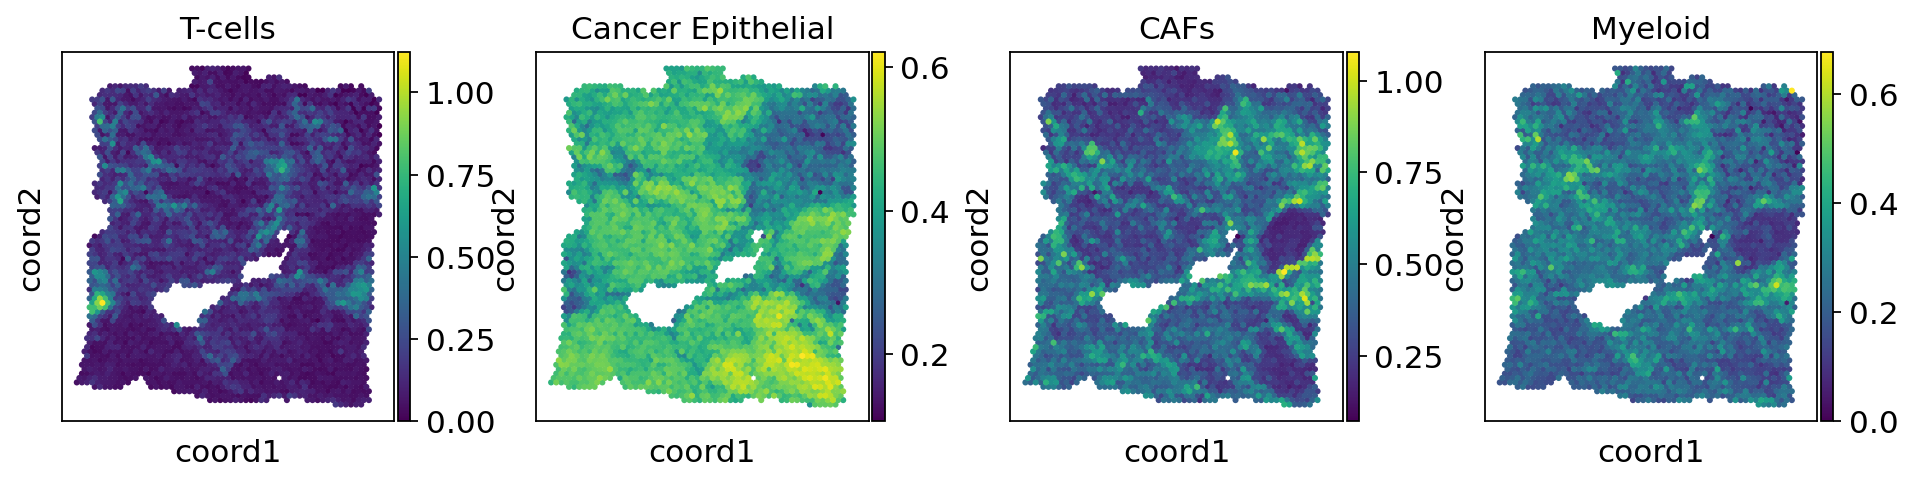

In [21]:
sc.set_figure_params(dpi=80, figsize=(2.7, 3))
sc.pl.embedding(adata, basis="coord", color=show_celltype, s=30, show=False)

[<AxesSubplot:title={'center':'T-cells'}, xlabel='coord1', ylabel='coord2'>,
 <AxesSubplot:title={'center':'Cancer Epithelial'}, xlabel='coord1', ylabel='coord2'>,
 <AxesSubplot:title={'center':'CAFs'}, xlabel='coord1', ylabel='coord2'>,
 <AxesSubplot:title={'center':'Myeloid'}, xlabel='coord1', ylabel='coord2'>]

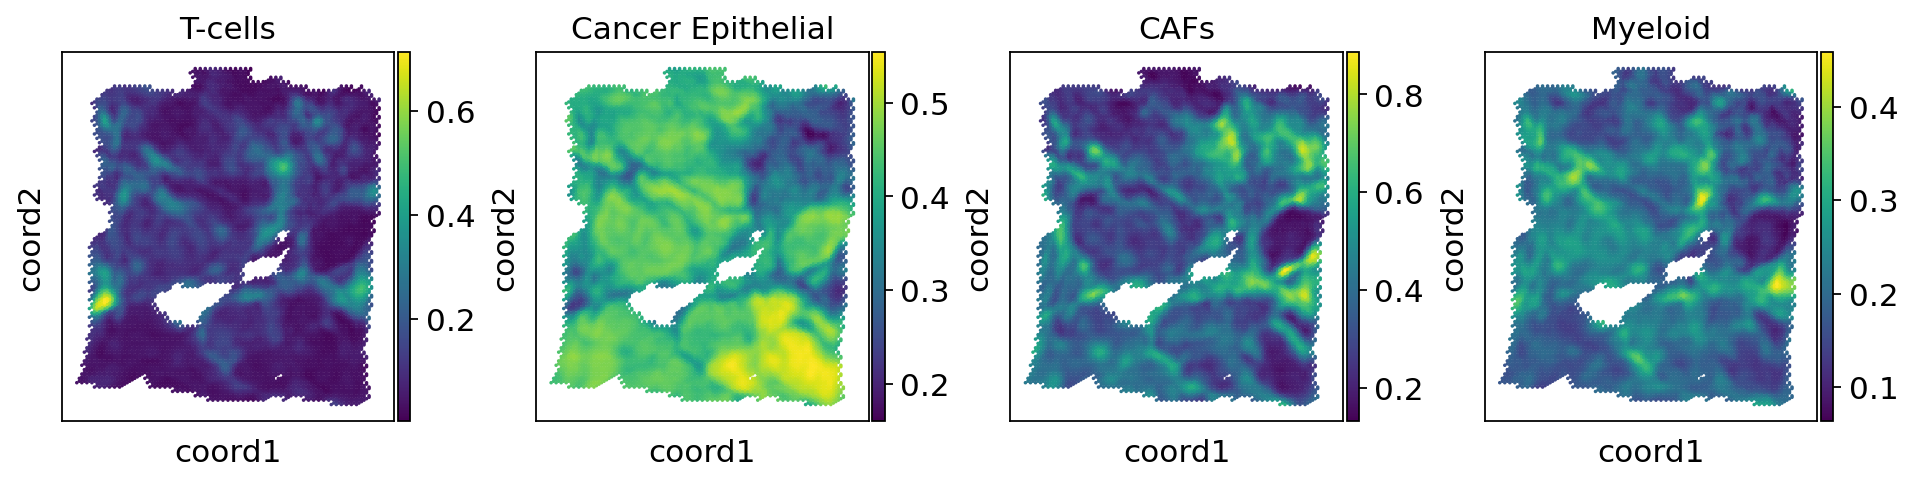

In [22]:
sc.set_figure_params(dpi=80, figsize=(2.7, 3))
sc.pl.embedding(adata_stage, basis="coord", color=show_celltype, s=10, show=False)

In [23]:
# Select corresponding marker genes
show_gene=["CD3D", "KRT18", "COL1A1", "LYZ"]

[<AxesSubplot:title={'center':'CD3D'}, xlabel='coord1', ylabel='coord2'>,
 <AxesSubplot:title={'center':'KRT18'}, xlabel='coord1', ylabel='coord2'>,
 <AxesSubplot:title={'center':'COL1A1'}, xlabel='coord1', ylabel='coord2'>,
 <AxesSubplot:title={'center':'LYZ'}, xlabel='coord1', ylabel='coord2'>]

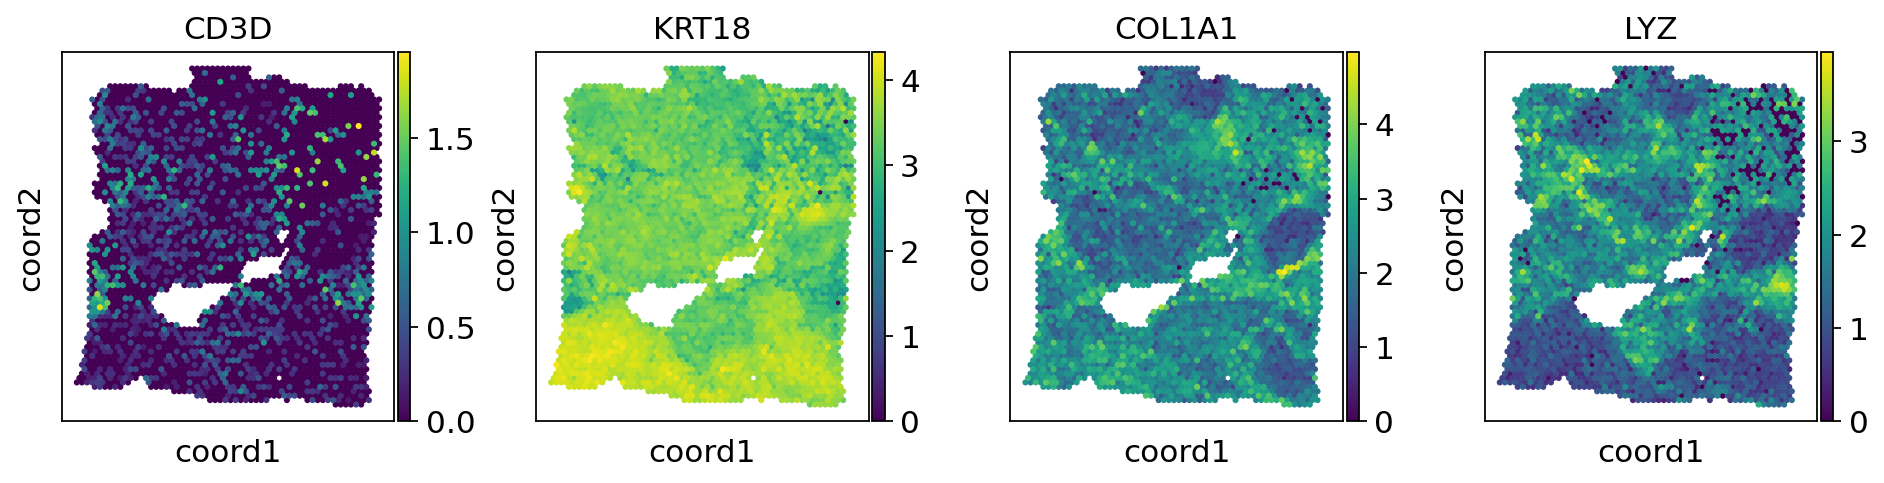

In [24]:
sc.set_figure_params(dpi=80, figsize=(2.7, 3))
sc.pl.embedding(adata, basis="coord", color=show_gene, s=30, show=False)

[<AxesSubplot:title={'center':'CD3D'}, xlabel='coord1', ylabel='coord2'>,
 <AxesSubplot:title={'center':'KRT18'}, xlabel='coord1', ylabel='coord2'>,
 <AxesSubplot:title={'center':'COL1A1'}, xlabel='coord1', ylabel='coord2'>,
 <AxesSubplot:title={'center':'LYZ'}, xlabel='coord1', ylabel='coord2'>]

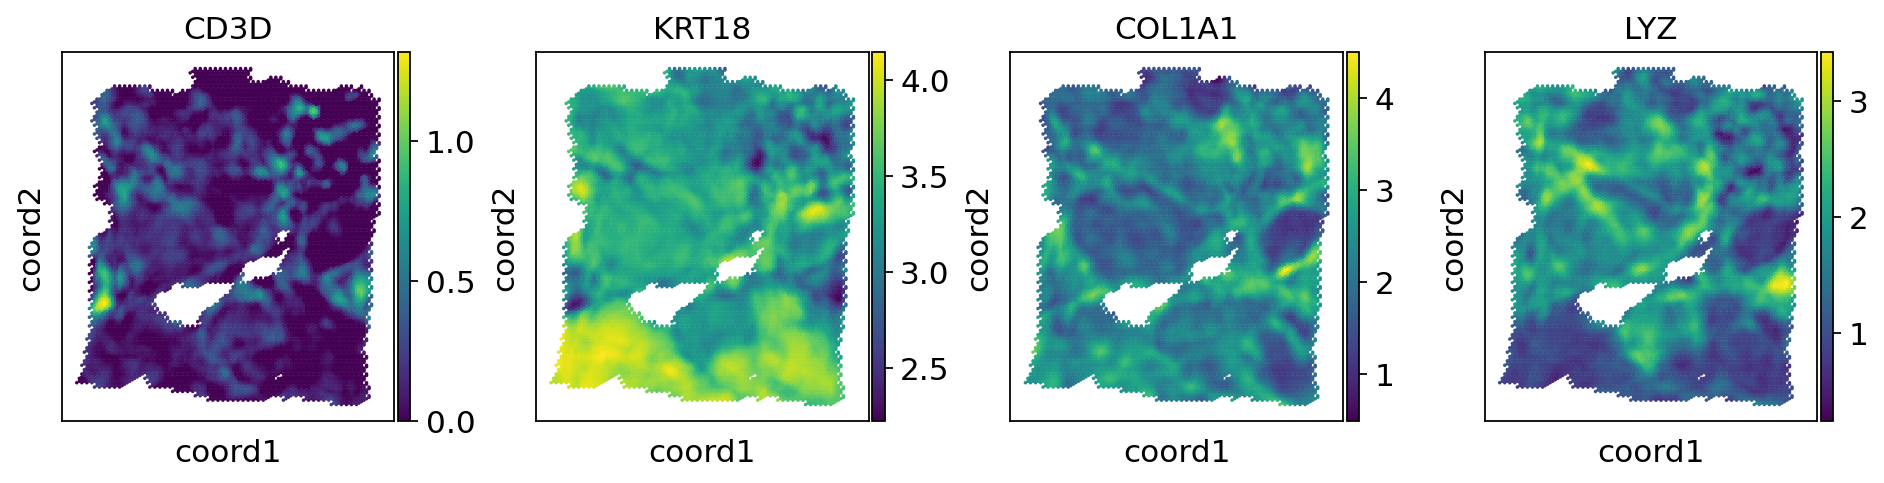

In [25]:
sc.set_figure_params(dpi=80, figsize=(2.7, 3))
sc.pl.embedding(adata_stage, basis="coord", color=show_gene, s=10, show=False)

## Tissue segmentation

In [26]:
# K-means clustering
model_raw=KMeans(n_clusters=3)
model_stage=KMeans(n_clusters=3)

In [27]:
# Model fit
model_raw.fit(adata.obs[DE_df.group.unique()])
model_stage.fit(adata_stage.obs[DE_df.group.unique()])

KMeans(n_clusters=3)

In [28]:
# Tissue domain prediction
adata.obs["K-means"]=model_raw.predict(adata.obs[DE_df.group.unique()])
adata_stage.obs["K-means"]=model_stage.predict(adata_stage.obs[DE_df.group.unique()])

In [29]:
adata.obs["segmentation"]=adata.obs["K-means"].replace([0,1,2],["R1", "R2", "R3"])
adata_stage.obs["segmentation"]=adata_stage.obs["K-means"].replace([0,1,2],["S1", "S2", "S3"])

In [30]:
adata.uns['segmentation_colors']=['#0000FF', '#FFFF00', '#FF0000']
adata_stage.uns['segmentation_colors']=['#0000FF', '#FFFF00', '#FF0000']

<AxesSubplot:xlabel='coord1', ylabel='coord2'>

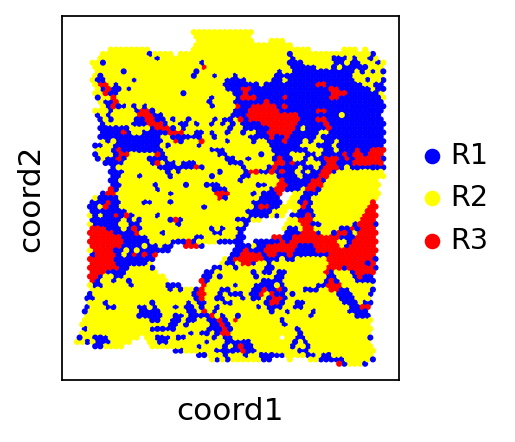

In [31]:
sc.set_figure_params(dpi=80, figsize=(2.7, 3))
sc.pl.embedding(adata, basis="coord", color="segmentation", title="", s=30, show=False)

<AxesSubplot:xlabel='coord1', ylabel='coord2'>

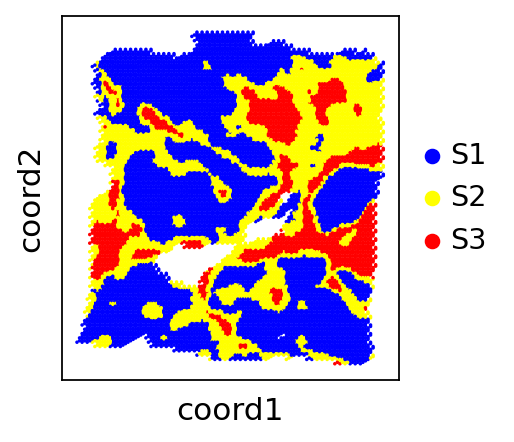

In [32]:
sc.set_figure_params(dpi=80, figsize=(2.7, 3))
sc.pl.embedding(adata_stage, basis="coord", color="segmentation", title="", s=10, show=False)